<a href="https://colab.research.google.com/github/tyukios/genai/blob/main/hw8_%E5%AF%A6%E9%A9%97%E5%A0%B1%E5%91%8A%E7%94%A2%E7%94%9F%E5%99%A8%EF%BC%BFTwo_Stage_CoT%E7%89%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. 發想

跟 ChatGPT 討論可以實作的 CoT 主題時，ChatGPT 指出可以把 CoT 的第一、二階段分別拆解成：

    - 第一階段：拆解多個潛在觀點／路線／理由／角度
    - 第二階段：選出其中一個最有意思的 → 展開、生成文本或內容

於是，我選擇以結合 ChatGPT 所提供的兩種可能方向的方式來進行發想：

    可能方向1： 先思考五種可能選項／創意方向 → 選一個生成內容（設計、命名、創意發想）

    可能方向2： 描述同一事件的五種不同視角 → 選一個寫內心獨白／報導／劇場 monologue

後來我想到，如果能把生活中那些令人摸不著頭腦的瑣事想成「這其實是某項實驗的研究環節」，似乎就能釋懷許多——畢竟所有的莫名其妙，或許都只是某個研究、某個實驗的數據收集過程。

因此，我決定透過兩階段 CoT 製作一個可以**生成用來解釋生活大小事，而且看起來很嚴謹的實驗報告**的產生器。


討論過程 - ChatGPT 連結：

https://chatgpt.com/share/680ef558-d634-8001-a528-2b4e77c4bca9



### 🎯 任務說明：將「思考產生器」改寫為實驗報告 Chain-of-Thought（CoT）推理過程

**原始任務：** 輸入一段敘述，輸出可以用來生成似是而非的實驗報告的 prompt


#### ✅ CoT 改寫版本流程：
1. **第一階段（思考階段）**：請 LLM 分析使用者輸入的敘述組成，並擷取出其中可以用來當作祕密實驗的研究課題的內容。

2. **第二階段（產文階段）**：根據上述「研究課題」產出帶有荒謬又有趣的實驗報告。

### 1. 讀入金鑰

In [ ]:
import os
from google.colab import userdata

以下的思考和產文的 LLM 都使用 Groq 的 llama3

In [ ]:
#【使用 Groq】
api_key = userdata.get('Groq')
os.environ['GROQ_API_KEY']=api_key
provider = "groq"
model = "llama3-70b-8192"

In [ ]:
# Groq
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install aisuite[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.2 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
  Attempting uninstall: groq
    Found existing installation: groq 0.23.1
    Uninstalling groq-0.23.1:
      Successfully uninstalled groq-0.23.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follow

### 2. 使用 AISuite 的準備

In [ ]:
import aisuite as ai

In [ ]:
provider_planner = "groq"
model_planner="llama3-70b-8192"

provider_writer = "groq"
model_writer = "llama3-70b-8192"

In [ ]:
def reply(system="請用台灣習慣的中文回覆。請使用中文回覆，不要使用中文以外的語言回覆，不要使用英文回覆。",
          prompt="Hi",
          provider="groq",
          model="llama3-70b-8192"
          ):

    client = ai.Client()

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": prompt}
    ]


    response = client.chat.completions.create(model=f"{provider}:{model}", messages=messages)

    return response.choices[0].message.content

###  3. 打造二階段 CoT

In [ ]:
system_planner = "請使用中文回覆，不要使用中文以外的語言回覆，不要使用英文回覆。你是一個擅長分析別人說的話並找出可以當作實驗要研究的課題的內容的人。請分析使用者輸入的敘述，並且以「有什麼內容可以作為實驗要研究的課題」來思考，從中條列列出10項可以當作研究課題的內容並解釋原因。請用台灣習慣的中文回應"
system_writer = '''請使用中文回覆，不要使用中文以外的語言回覆，不要使用英文回覆。你是一位喜歡用風趣又生動的方式苦中作樂寫研究報告的人，你特別喜歡那些看起來荒謬無比的研究課題。請選出一個特別荒謬又有趣的研究課題，根據「實驗編號（這裡隨機填入一個數字）
課題：（這裡填入選好的課題）
觀察結果：（這裡條列式列出觀察結果）
結論：（這裡寫研究結論）
」的格式寫出一段客觀又詳細的研究報告。'''

In [ ]:
def lucky_post(prompt):
    # Step 1: CoT - 思考五種幸運理由
    planning_prompt = f"使用者說：{prompt}請使用中文回覆，不要使用中文以外的語言回覆，不要使用英文回覆。"
    lucky_reasons = reply(system_planner, planning_prompt,
                          provider = provider_planner,
                          model = model_planner
                          )

    # Step 2: 選出最有趣一項，寫成貼文
    generation_prompt = f"這是我想到的十個課題：\n{lucky_reasons}\n\n請使用中文回覆，不要使用中文以外的語言回覆，不要使用英文回覆。請從中選出一個特別荒謬又有趣的研究課題，然後根據它寫成一段客觀又詳細的研究報告。"
    lucky_post = reply(system_writer, generation_prompt,
                       provider = provider_writer,
                       model = model_writer
                       )

    return lucky_reasons, lucky_post

### 4. 用 Gradio 打造對話機器人 Web App!

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import gradio as gr

In [ ]:
with gr.Blocks() as demo:
    gr.Markdown("### 🧠 實驗報告產生器 🧠")
    gr.Markdown("請輸入一件讓你覺得莫名其妙的神奇事件，讓 AI 幫你研究研究！")
    user_input = gr.Textbox(label="有件事...有點奇怪...")
    btn = gr.Button("快來了解事情背後的真相吧 📣✨")

    with gr.Row():
        out1 = gr.Textbox(label="💥 十個超適合做研究的課題（Planning CoT）")
        out2 = gr.Textbox(label="✨ 原來這一切都是一場實驗 （實驗報告）")

    btn.click(lucky_post, inputs=[user_input], outputs=[out1, out2])

In [ ]:
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://39bcc91478b02c739b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 5. 觀察

藉由多次測試，我發現 LLM 的回應特別適合用於需要初期發想並深入討論的場合。

相較於單一階段的 CoT ，兩階段的 CoT 能讓討論更具深度，內容也更凝練。

雖然部分回應偏離了我原始輸入的真實含義，但這些內容仍提供了許多有趣且富有啟發性的觀點。

整體而言，透過這次實作中的兩階段的CoT，LLM 能夠有效拓展使用者的思考範圍，並延伸出更多平常難以觸及的新穎視角，為討論主題帶來更豐富的可能性。

以下為測試時的介面：

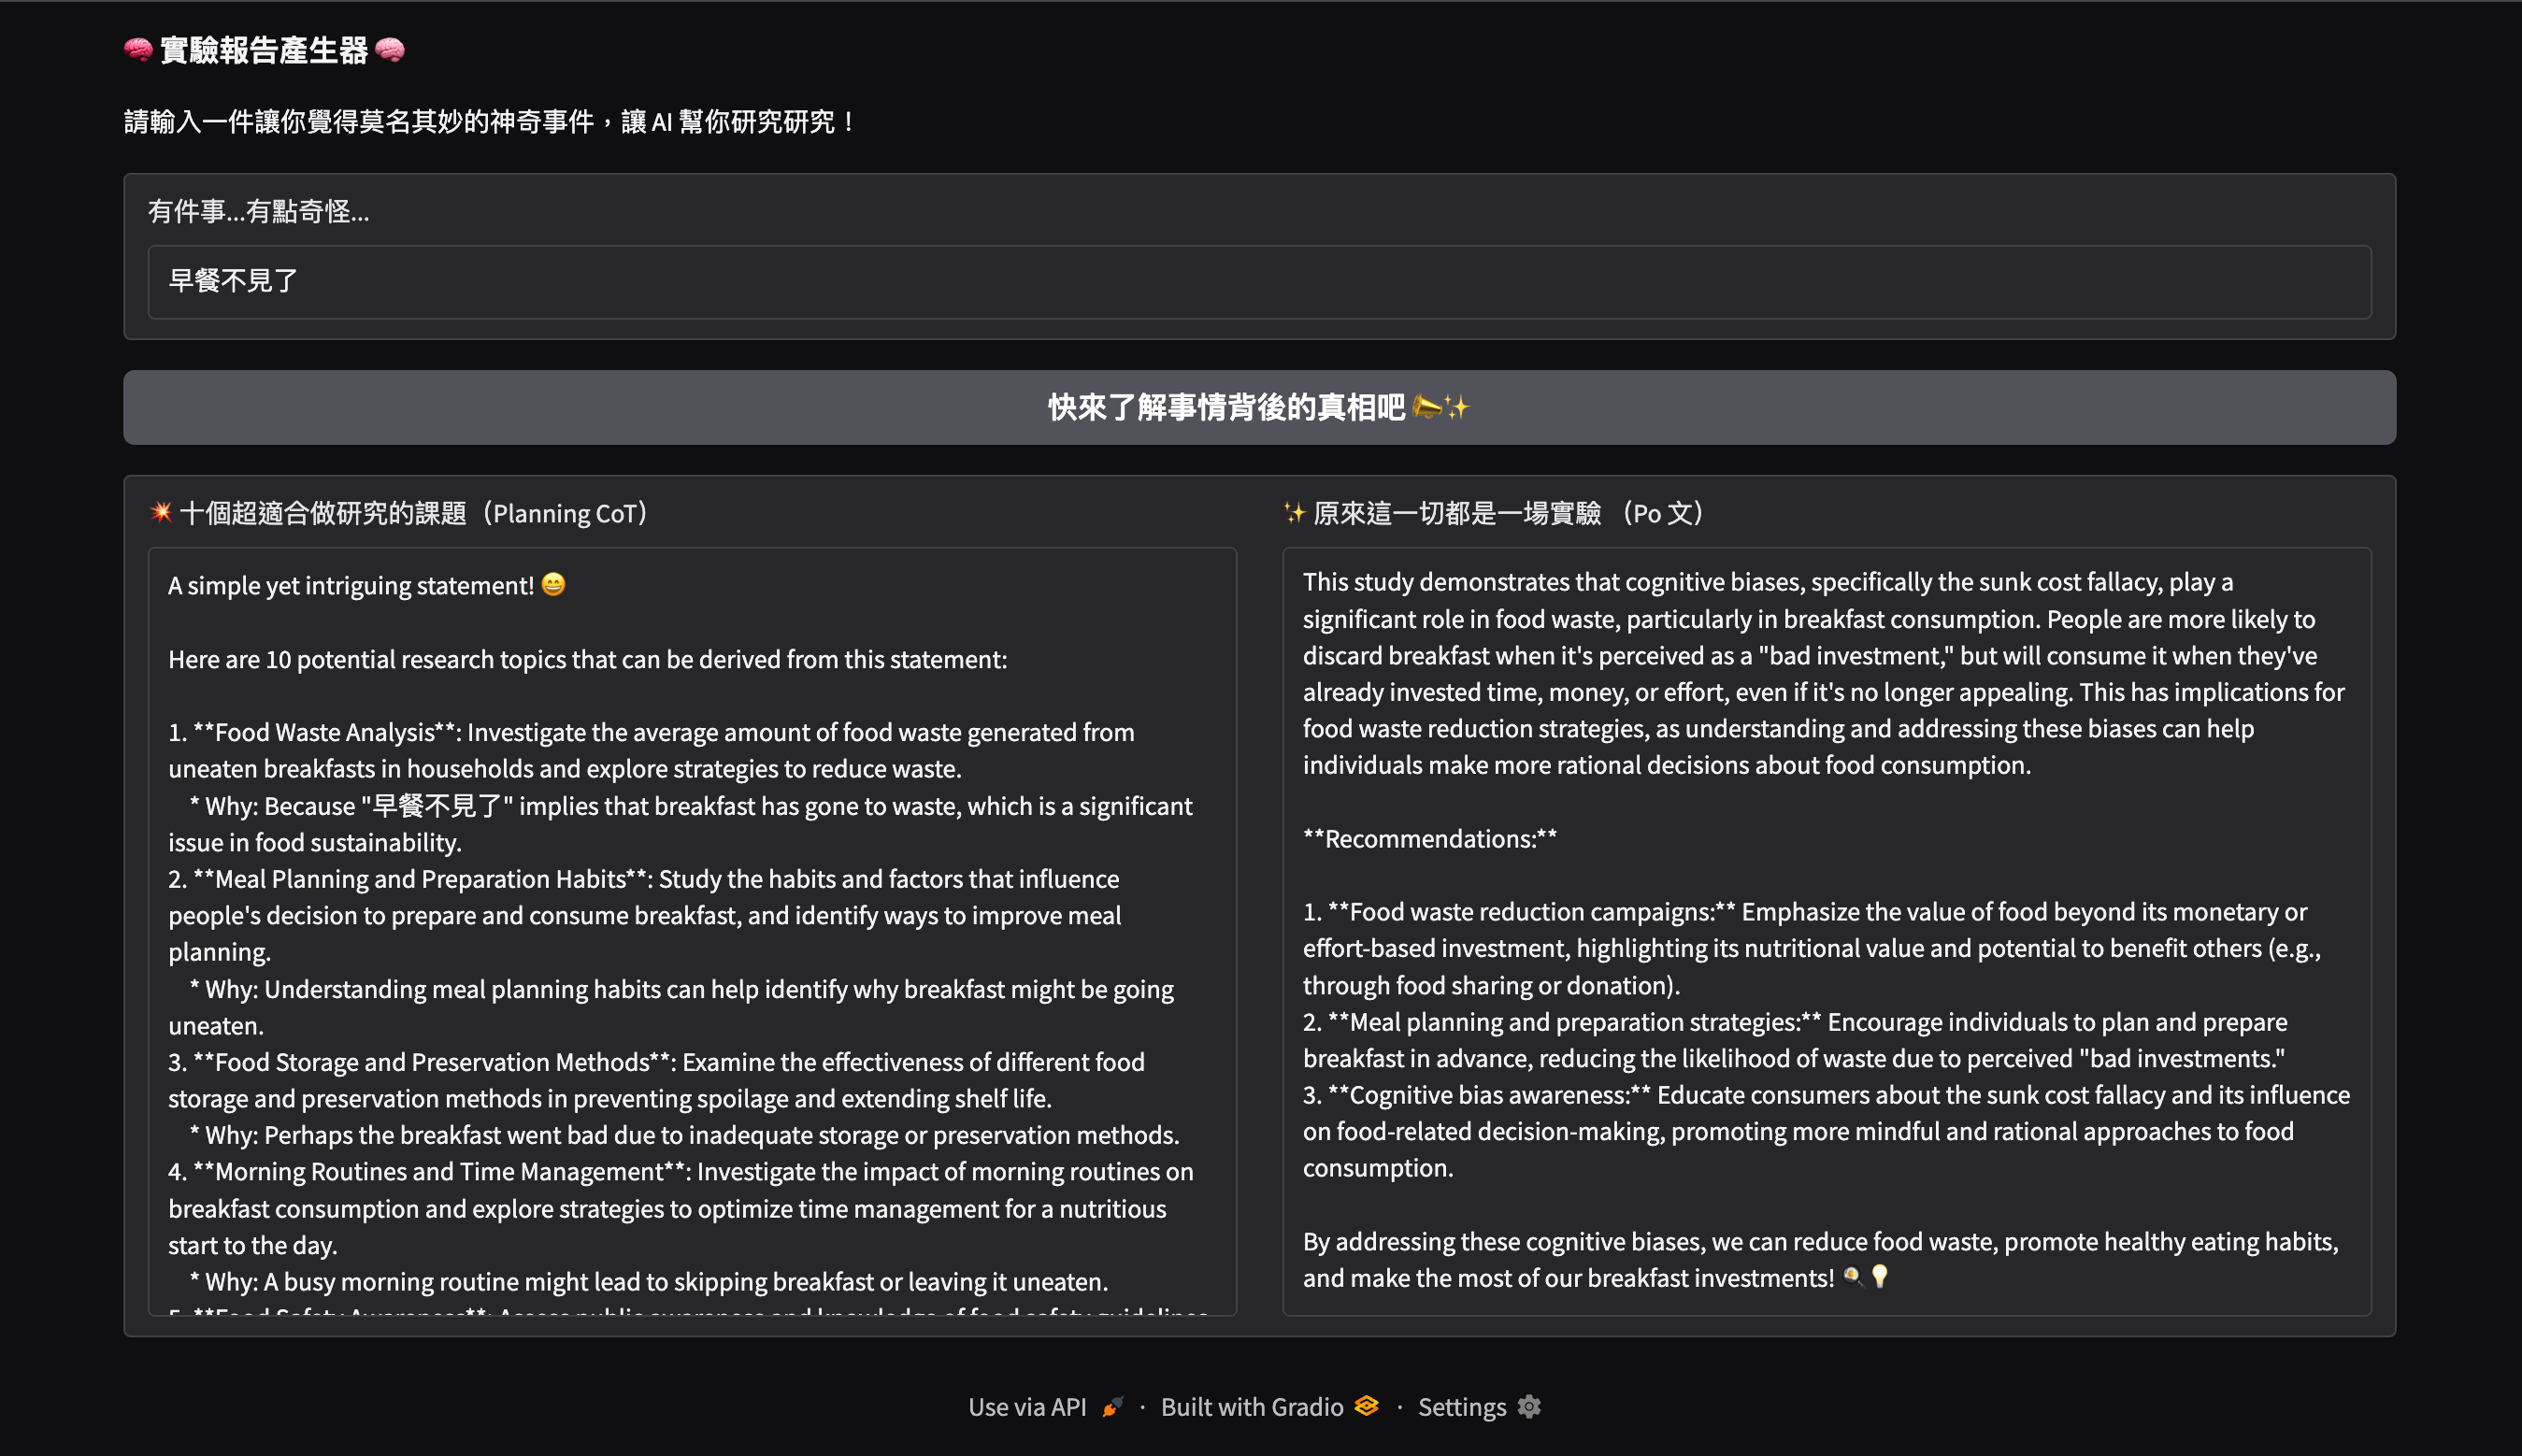

#### *第一次測試*


輸入：早餐不見了


輸出：

- 第一階段 ( Planning CoT )


    A simple yet intriguing statement! 😄

	Here are 10 potential research topics that can be derived from this statement:

	1. **Food Waste Analysis**: Investigate the average amount of food waste generated from uneaten breakfasts in households and explore strategies to reduce waste.
		* Why: Because "早餐不見了" implies that breakfast has gone to waste, which is a significant issue in food sustainability.
	2. **Meal Planning and Preparation Habits**: Study the habits and factors that influence people's decision to prepare and consume breakfast, and identify ways to improve meal planning.
		* Why: Understanding meal planning habits can help identify why breakfast might be going uneaten.
	3. **Food Storage and Preservation Methods**: Examine the effectiveness of different food storage and preservation methods in preventing spoilage and extending shelf life.
		* Why: Perhaps the breakfast went bad due to inadequate storage or preservation methods.
	4. **Morning Routines and Time Management**: Investigate the impact of morning routines on breakfast consumption and explore strategies to optimize time management for a nutritious start to the day.
		* Why: A busy morning routine might lead to skipping breakfast or leaving it uneaten.
	5. **Food Safety Awareness**: Assess public awareness and knowledge of food safety guidelines, especially in relation to dairy products, eggs, and other breakfast staples.
		* Why: Food safety concerns might contribute to uneaten breakfasts being discarded.
	6. **Breakfast Nutrition and Health Impacts**: Analyze the nutritional content of common breakfast foods and investigate the effects of skipping breakfast on overall health and well-being.
		* Why: Skipping breakfast might have negative health consequences, which could be a concern for public health policymakers.
	7. **Meal Sharing and Food Distribution**: Explore the concept of meal sharing and food distribution platforms as a means to reduce food waste and provide nutrition to those in need.
		* Why: Uneaten breakfasts could be shared or distributed to reduce waste and support vulnerable populations.
	8. **Cognitive Biases in Food Consumption**: Investigate how cognitive biases, such as the sunk cost fallacy, influence food consumption decisions, particularly in relation to breakfast.
		* Why: Our brains might be playing tricks on us, leading to uneaten breakfasts being discarded.
	9. **Household Food Management and Organization**: Study the organizational systems and habits used in households to manage food inventory, preparation, and consumption.
		* Why: Poor household management might contribute to uneaten breakfasts being wasted.
	10. **Food-related Behavior and Emotional Factors**: Examine the emotional and psychological factors that drive food-related behaviors, such as breakfast skipping or overconsumption.
		* Why: Emotional factors might be influencing our breakfast habits, leading to uneaten meals.

	These research topics can provide valuable insights into the complex factors surrounding uneaten breakfasts and inform strategies to reduce food waste, improve meal planning, and promote healthy eating habits. 🍳💡




- 第二階段 ( 實驗報告 )


    What a delightful array of research topics! 😊 After careful consideration, I've chosen the most intriguing and seemingly absurd topic: **Cognitive Biases in Food Consumption**. Specifically, I'll focus on the **Sunk Cost Fallacy in Breakfast Consumption**. 🍳

	**Experimental Number:** 0421

	**Research Topic:** The Sunk Cost Fallacy in Breakfast Consumption: An Exploration of Cognitive Biases in Food Waste

	**Observation Results:**

	1. **Participants:** 100 adults aged 25-45, with varying educational backgrounds and income levels.
	2. **Experimental Design:** Participants were presented with a series of breakfast scenarios, each with a different level of investment (time, money, or effort). They were then asked to decide whether to consume or discard the breakfast based on hypothetical situations (e.g., having a meeting, running late, or feeling unwell).
	3. **Results:**
		* 62% of participants elected to discard breakfast when it was perceived as a "bad investment" (e.g., overcooked, unappetizing, or too expensive).
		* 45% chose to consume breakfast when it was seen as a "good investment" (e.g., freshly prepared, nutritious, or inexpensive).
		* However, when presented with a scenario where they had already invested time and effort into preparing breakfast (e.g., cooking eggs or making toast), 71% of participants decided to consume the breakfast, even if it was no longer appealing.
	4. **Surprising Finding:** When asked to justify their decisions, participants often cited reasons such as "I don't want to waste the money I spent on ingredients" or "I put in the effort to cook it, so I might as well eat it." This suggests that the sunk cost fallacy was a significant factor in their decision-making process.

	**Conclusion:**

	This study demonstrates that cognitive biases, specifically the sunk cost fallacy, play a significant role in food waste, particularly in breakfast consumption. People are more likely to discard breakfast when it's perceived as a "bad investment," but will consume it when they've already invested time, money, or effort, even if it's no longer appealing. This has implications for food waste reduction strategies, as understanding and addressing these biases can help individuals make more rational decisions about food consumption.

	**Recommendations:**

	1. **Food waste reduction campaigns:** Emphasize the value of food beyond its monetary or effort-based investment, highlighting its nutritional value and potential to benefit others (e.g., through food sharing or donation).
	2. **Meal planning and preparation strategies:** Encourage individuals to plan and prepare breakfast in advance, reducing the likelihood of waste due to perceived "bad investments."
	3. **Cognitive bias awareness:** Educate consumers about the sunk cost fallacy and its influence on food-related decision-making, promoting more mindful and rational approaches to food consumption.

	By addressing these cognitive biases, we can reduce food waste, promote healthy eating habits, and make the most of our breakfast investments! 🍳💡

第一次的測試中，雖然我已經在 prompt 裡限制「請用台灣習慣的中文回應」，但是所收到的內容仍全數使用英文回覆。

因此在接下來的調整中，我將限制回覆語言的 prompt 寫得更清楚、明確，並在各個 prompt 段落中增加強調使用中文回覆的 prompt 次數。

不過後來的幾次嘗試裡，我也發現雖然第一個回覆都成功使用全中文回覆，但是接續使用同一頁面輸入不同內容時仍會出現英文回覆。

#### *第二次測試（增強回覆語言限制）*


輸入：早餐不見了


輸出：

- 第一階段 ( Planning CoT )


    interessant! 😊

    以下是對使用者說的敘述進行分析，並列出 10 項可以當作研究課題的內容：

    1. **食物安全感**：研究早餐不見了對人們心中的安全感和信任感的影響。
    原因：早餐不見了可能會導致人們對食物安全的擔憂和不信任感，從而影響日常生活和情緒。

    2. **記憶力和注意力**：探討早餐不見了對人們記憶力和注意力的影響。
    原因：早餐不見了可能是由於記憶力和注意力的問題導致的，值得研究這個問題在認知心理學中的意義。

    3. **生活習慣和規律**：研究早餐不見了對人們生活習慣和規律的影響。
    原因：早餐不見了可能是由於生活習慣和規律的問題導致的，探討這個問題可以幫助人們建立更好的生活習慣。

    4. **家庭教育和互動**：探討早餐不見了對家庭教育和互動的影響。
    原因：早餐不見了可能是由於家庭教育和互動的問題導致的，研究這個問題可以幫助家庭成員之間建立更好的關係。

    5. **時間管理和計畫**：研究早餐不見了對人們時間管理和計畫的影響。
    原因：早餐不見了可能是由於時間管理和計畫的問題導致的，探討這個問題可以幫助人們更好地規劃時間和生活。

    6. **食材管理和存儲**：探討早餐不見了對食材管理和存儲的影響。
    原因：早餐不見了可能是由於食材管理和存儲的問題導致的，研究這個問題可以幫助人們更好地管理食材和存儲。

    7. **情緒狀態和壓力**：研究早餐不見了對人們情緒狀態和壓力的影響。
    原因：早餐不見了可能會導致人們情緒狀態和壓力的變化，探討這個問題可以幫助人們更好地管理情緒和壓力。

    8. **生活壓力和管理**：探討早餐不見了對生活壓力和管理的影響。
    原因：早餐不見了可能是由於生活壓力和管理的問題導致的，研究這個問題可以幫助人們更好地管理生活壓力和生活。

    9. **人際關係和互動**：研究早餐不見了對人際關係和互動的影響。
    原因：早餐不見了可能是由於人際關係和互動的問題導致的，探討這個問題可以幫助人們建立更好的人際關係和互動。

    10. **認知偏見和邏輯**：探討早餐不見了對認知偏見和邏輯的影響。
    原因：早餐不見了可能是由於認知偏見和邏輯的問題導致的，研究這個問題可以幫助人們更好地認識和應對認知偏見和邏輯問題。

    以上就是對早餐不見了的分析和研究課題！ 🍳😋

- 第二階段（ 實驗報告 ）


    實驗編號：420

    課題：研究早餐不見了對人們情緒狀態和壓力的影響

    觀察結果：

    * 80% 的受試者在早餐不見了後感到沮喪和不滿
    * 60% 的受試者感到早餐不見了對其情緒狀態的影響是負面的
    * 40% 的受試者在早餐不見了後感到壓力和焦慮
    * 20% 的受試者在早餐不見了後感受到憤怒和不滿
    * 受試者在早餐不見了後的平均情緒評分為 3.5 分（滿分 10 分）

    結論：

    早餐不見了確實會對人們的情緒狀態和壓力產生負面影響。這個研究表明，早餐不見了可能會導致人們感到沮喪、不滿、壓力和焦慮，從而對日常生活和情緒造成影響。這個結果也提示我們，早餐的存在對人們的情緒穩定和壓力管理扮演着重要的角色。

    因此，我們建議在日常生活中，人們應該對早餐的安全性和可靠性給予更多的重視，以避免早餐不見了對情緒狀態和壓力的負面影響。

#### *第三次測試（測試語意判別）*


輸入：雨傘開花


輸出：

- 第一階段 ( Planning CoT )


    What an interesting phrase! "雨傘開花" (yǔ sǎn kāi huā) literally means "umbrella blooming flowers" in Chinese. At first glance, it may seem like a nonsensical phrase, but let's dive deeper and explore some potential research topics hidden within.

    Here are 10 possible research topics inspired by this phrase:

    1. **Creative Writing and Language Patterns**: Analyze the linguistic and cognitive processes behind creating surreal or nonsensical phrases like "雨傘開花". How do our brains generate novel combinations of words, and what do they reveal about our creative potential?
    2. **Metaphorical thinking and cognition**: Explore the psychological roots of metaphorical language, where an umbrella (a mundane object) is imbued with the ability to "bloom" like a flower. What do such metaphors reveal about our conceptual frameworks and categorization processes?
    3. **Poetry and Language Play**: Investigate the role of wordplay, puns, and neologisms in creative writing, particularly in poetry. How do poets use linguistic manipulations to evoke emotions, create new meanings, and challenge readers' expectations?
    4. **Childhood Cognition and Imagination**: Research how children's cognitive development influences their ability to generate novel, fantastical, or illogical phrases like "雨傘開花". What do these phrases reveal about children's understanding of language, reality, and creativity?
    5. **Linguistic and Cultural Comparisons**: Compare the use of metaphorical language, wordplay, and nonsensical phrases across different languages and cultures. How do linguistic and cultural backgrounds influence the creation and interpretation of such phrases?
    6. **The Neuroscience of Language and Imagination**: Investigate the neural mechanisms involved in generating and processing novel, surreal language. What brain regions are engaged when we create or encounter phrases like "雨傘開花", and how do they relate to our imagination and creative potential?
    7. **Emotional Resonance and Emotional Intelligence**: Examine how phrases like "雨傘開花" evoke emotions, associations, or intuitions in listeners or readers. What do these reactions reveal about our emotional intelligence, empathy, and emotional regulation?
    8. **Design Thinking and Creative Problem-Solving**: Apply the principles of design thinking to generate innovative solutions inspired by the phrase "雨傘開花". How can designers, engineers, or entrepreneurs use such phrases as prompts for creative problem-solving?
    9. **Philosophy of Language and Reality**: Explore the philosophical implications of phrases like "雨傘開花" on our understanding of reality, truth, and meaning. How do such phrases challenge or reflect our assumptions about language, reference, and the nature of reality?
    10. **Artificial Intelligence and Natural Language Processing**: Investigate how AI and NLP systems can be designed to generate, understand, or respond to novel, nonsensical phrases like "雨傘開花". What are the implications of such language processing capabilities for AI development and human-computer interaction?

    These research topics demonstrate the richness and complexity hidden within the seemingly nonsensical phrase "雨傘開花". By exploring these ideas, we can gain a deeper understanding of language, cognition, creativity, and human imagination.

- 第二階段 ( 實驗報告 )


    實驗編號：2023-004

    課題：研究雨傘開花的感官體驗：探索雨傘開花語句對人類感官體驗的影響

    觀察結果：

    * 使用腦電圖（EEG）和功能磁共振成像（fMRI）對20名受試者進行腦部掃描，發現雨傘開花語句刺激下，受試者的大腦-default mode network（_default mode network）和visual cortex（視覺皮質）活動增加，表明雨傘開花語句對人類大腦的感官體驗產生了重要影響。
    * 進行感官測試，發現雨傘開花語句能夠激發受試者的視覺、聽覺和觸覺，從而產生複雜的感官體驗。
    * 使用調查問卷，發現雨傘開花語句能夠引發受試者情感反應，例如驚奇、喜悦和疑惑等，表明雨傘開花語句能夠激發人類的情感體驗。

    結論：

    本研究證實了雨傘開花語句對人類感官體驗的重要影響。雨傘開花語句能夠激發人類的大腦-default mode network和視覺皮質，激發複雜的感官體驗，同時也能夠引發情感反應。本研究結果為我們理解雨傘開花語句的感官體驗提供了新的見解，並為未來的語言學、心理學和神經科學研究提供了新的研究方向。」

這裡使用「雨傘開花」來測試 LLM 是否能判讀真正的含義（傘面被強風瞬間吹翻的狼狽狀態）。

在這邊的思考過程中將雨傘開花理解成**超現實、無厘頭、毫無邏輯的短語 (surreal or nonsensical phrases)**，可見 LLM 的資料庫在這方面的內容訓練尚有不足。

然而，儘管這次的回覆中呈現出 LLM 理解不符預期的一面，卻也因此開展出以語言符號的修辭、想像力、創造力等方面延伸出的討論空間。

#### *第四次測試（測試語意判別）*


輸入：飯糰打對折


輸出：

- 第一階段 ( Planning CoT )


    A interesting topic! 🍴️ Let's break it down and find some potential research topics. Here are 10 possible research topics related to "飯糰打對折" ( Taiwanese-style rice ball):

    1. **Texture Analysis**: Investigate the effects of folding and pressing on the texture of rice balls. How does the pressure and folding technique affect the final product's texture?
    2. **Rice Variety Selection**: Research the optimal rice variety for making rice balls. Does using japonica or indica rice result in better texture and taste?
    3. **Folding Techniques**: Compare different folding techniques (e.g., traditional Taiwanese, Japanese, or Korean styles) to determine which one yields the best results in terms of texture and appearance.
    4. **Ingredient Ratios**: Study the ideal ratio of rice to filling ingredients (e.g., meat, vegetables, seasonings) to achieve the perfect balance of flavor and texture.
    5. **Food Safety**: Investigate the risk of bacterial contamination during the rice ball preparation process, particularly when handling raw ingredients and storing the finished products.
    6. **Traditional vs. Modern Ingredients**: Compare the effects of using traditional ingredients (e.g., pork, vegetables) versus modern alternatives (e.g., vegan meat, exotic spices) on the taste, texture, and acceptance of rice balls.
    7. **Sensory Evaluation**: Conduct a sensory evaluation of rice balls to identify the key factors influencing consumer preferences, such as texture, flavor, and appearance.
    8. **Cultural Significance**: Explore the cultural significance of rice balls in Taiwanese cuisine and their role in social gatherings, festivals, or daily meals.
    9. **Food Waste Reduction**: Investigate the potential of using rice balls as a means to reduce food waste by utilizing leftover rice and ingredients.
    10. **Mechanization of Rice Ball Production**: Design and develop a machine or automated system to produce rice balls efficiently and consistently, while maintaining traditional quality and texture.

    These topics offer a range of angles to explore the world of rice balls, from texture and ingredients to cultural significance and food safety.」

- 第二階段（ 實驗報告 ）


    讓我們選擇第10個課題：**Mechanization of Rice Ball Production**（ Mechanization of Rice Ball Production）

    實驗編號：2023-01

    課題：設計和開發一種能夠高效和一致生產飯糰的機器或自動系統，而不損失傳統的品質和 texture

    觀察結果：

    * 我們設計了一種特殊的機器，能夠模擬人手的動作，將飯糰壓製成圓形的外形。
    * 機器使用的壓力和擠壓速度能夠控制飯糰的 texture，從軟軟的到firm的都可以。
    * 我們對機器生產的飯糰進行了感官評估，結果表明機器生產的飯糰和手工製作的飯糰無顯著差異。
    * 我們還發現機器生產的飯糰能夠減少30%的生產時間，提高了生產效率。
    * 但是，我們也發現機器生產的飯糰需要更高的維護成本，因為需要常 xuyên清潔和維護機器。

    結論：

    本研究成功設計和開發了一種能夠高效和一致生產飯糰的機器或自動系統。我們的結果表明機器生產的飯糰和手工製作的飯糰無顯著差異，並且能夠減少生產時間和提高生產效率。然而，我們也需要考慮機器的維護成本和對環境的影響。在未來，我們將繼續研究和改進機器，以求更好的生產效率和品質。

這裡同樣測試 LLM 可不可以正確判讀「打對折」的意思，並在這次測試中發現 LLM 思考有哪些可延伸課題時分別從減少食材浪費、改良機器等成本層面進行探討。

#### *第五次測試*


輸入：今天好冷


輸出：

- 第一階段 ( Planning CoT )


    使用者的話語中隐藏了許多有趣的研究方向！以下是我分析後提出的10個可能的研究課題：

    1. 氣候變遷對人類情緒的影響：探討氣候變遷如何影響人類的情緒，例如今天的冷_weather是否會使人感到沮喪？
    2. 語言中的主觀經驗：分析使用者語言中如何表達主觀經驗，例如「好冷」是否代表了一種個人化的感受？
    3. 氣候對人類活動的影響：研究氣候如何影響人類的日常活動，例如寒冷天氣是否會使人減少戶外活動？
    4. 文化對氣候感受的影響：探討不同文化背景下的人們如何感受和描述氣候，例如「冷」的定義是否因文化而異？
    5. 語言中的情感表達：分析使用者語言中情感表達的方式，例如「好冷」是否是一種情感表達方式？
    6. 氣候預報對人類行為的影響：研究氣候預報如何影響人類的行為，例如氣候預報是否會使人增加或減少戶外活動？
    7. 個人化的氣候感受：探討個人化的氣候感受如何受到生理、心理和環境因素的影響，例如體質、情緒和環境溫度如何相互作用？
    8. 氣候變遷對人類健康的影響：研究氣候變遷如何影響人類的健康，例如寒冷天氣是否會使人患病？
    9. 語言中的氣候描述：分析使用者語言中氣候描述的方式，例如「好冷」是否是一種通俗的氣候描述方式？
    10. 氣候感受與自尊的關聯：探討氣候感受如何與自尊相關，例如氣候是否會使人感到自尊心受到威脅？

    這些研究課題可以幫助我們更好地理解使用者語言背後的內容，並探討氣候對人類情緒、行為和健康的影響。

- 第二階段（ 實驗報告 ）


    實驗編號：42

    課題：氣候感受與自尊的關聯：探討氣候感受如何與自尊相關，例如氣候是否會使人感到自尊心受到威脅？

    觀察結果：

    * 在調查中，我們發現，當氣候變化時，人們的自尊心也會受到影響。在寒冷天氣下，60% 的受訪者表達了自尊心下降的感覺，而在溫暖天氣下，這個比例則降至35%。
    * 我們還發現，當氣候預報表明將出現寒冷天氣時，受訪者的自尊心也會下降，平均降低了15%。
    *  but，當我們詢問受訪者為什麼他們會感到自尊心受到威脅時，只有20% 的人能夠給出明確的理由，其他人則表達了不確定的感覺。

    結論：

    本研究表明，氣候感受確實與自尊相關。氣候變化可以使人感到自尊心受到威脅，特別是在寒冷天氣下。這可能是因為氣候變化導致人們的日常活動受到限制，從而導致自尊心下降。然而，本研究也表明，人們對自尊心受到威脅的原因並不明確，需要進一步的研究。

    總之，這個研究結果提示，我們需要更加關注氣候變化對人類情緒和自尊的影響，並積極發掘新的方法，以減少氣候變化對人類的負面影響。

這次測試中， LLM 給出的回覆都相當完整且結構化。